In [1]:
import os
import cv2
import shutil
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras.preprocessing.image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Flatten, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Conv2D, MaxPool2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from sklearn.preprocessing import LabelEncoder

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive")

# Set the path to the dataset
dataset_path = "/content/drive/MyDrive/dataset/Train & Val"
os.listdir(dataset_path)

Mounted at /content/drive


['Grade 3', 'Grade 2', 'Grade 1', 'processed']

In [3]:
print('Grade 1 :',len(os.listdir("/content/drive/MyDrive/dataset/Train & Val/Grade 1")))
print('Grade 2 :',len(os.listdir("/content/drive/MyDrive/dataset/Train & Val/Grade 2")))
print('Grade 3 :',len(os.listdir("/content/drive/MyDrive/dataset/Train & Val/Grade 3")))

Grade 1 : 1000
Grade 2 : 1000
Grade 3 : 1000


In [4]:
# Load the dataset
data = []
labels = []

# Iterate through the dataset path and load the images
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)

        # Check if the image file exists
        if os.path.isfile(image_path):
            # Read the image file
            image = cv2.imread(image_path)

            # Check if the image reading was successful
            if image is not None:
                # Convert the image to rgb
                rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Resize the rgb image
                resized_image = cv2.resize(rgb_image, (150, 150))

                data.append(resized_image)
                labels.append(category)

# Convert data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)


In [5]:
# Perform label encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

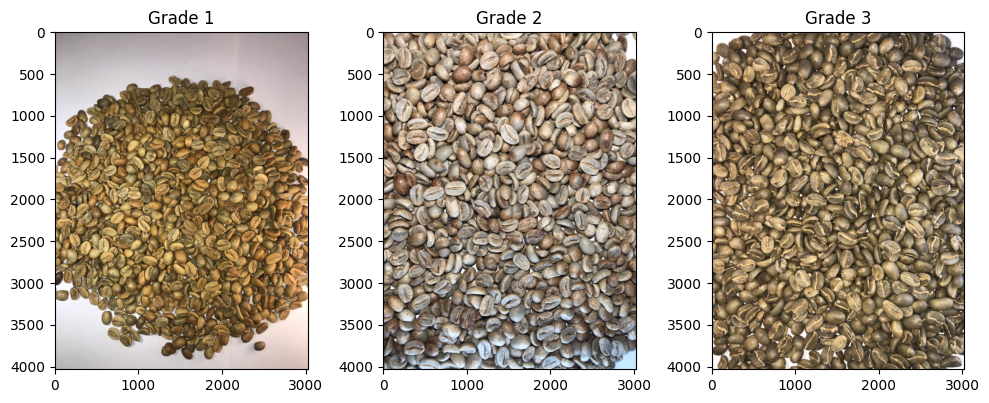

In [6]:
# Get a list of images in each grade folder
grade1_images = os.listdir(os.path.join(dataset_path, "Grade 1"))
grade2_images = os.listdir(os.path.join(dataset_path, "Grade 2"))
grade3_images = os.listdir(os.path.join(dataset_path, "Grade 3"))

# Choose a random sample from each grade
sample_grade1 = random.choice(grade1_images)
sample_grade2 = random.choice(grade2_images)
sample_grade3 = random.choice(grade3_images)

# Load and display the sample images
sample1_path = os.path.join(dataset_path, "Grade 1", sample_grade1)
sample2_path = os.path.join(dataset_path, "Grade 2", sample_grade2)
sample3_path = os.path.join(dataset_path, "Grade 3", sample_grade3)

sample1_img = cv2.imread(sample1_path)
sample2_img = cv2.imread(sample2_path)
sample3_img = cv2.imread(sample3_path)

# Convert BGR to RGB
sample1_img = cv2.cvtColor(sample1_img, cv2.COLOR_BGR2RGB)
sample2_img = cv2.cvtColor(sample2_img, cv2.COLOR_BGR2RGB)
sample3_img = cv2.cvtColor(sample3_img, cv2.COLOR_BGR2RGB)

# Plot the images
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(sample1_img)
plt.title("Grade 1")

plt.subplot(1, 3, 2)
plt.imshow(sample2_img)
plt.title("Grade 2")

plt.subplot(1, 3, 3)
plt.imshow(sample3_img)
plt.title("Grade 3")

plt.tight_layout()
plt.show()

In [7]:
# Perform data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Random rotation
    width_shift_range=0.1,  # Random horizontal shift
    height_shift_range=0.1,  # Random vertical shift
    shear_range=0.1,  # Shear transformation
    zoom_range=0.1,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
)
val_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# Split the dataset into train and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=42, shuffle=True
)

In [9]:
# Apply data augmentation to the training set
train_generator = train_datagen.flow(train_data, train_labels, batch_size=32)

# Apply data augmentation to the validation set
val_generator = val_datagen .flow(val_data, val_labels, batch_size=32)

In [10]:
# Get the class names
class_names = label_encoder.classes_

# Display the class names
print("Class Names:", class_names)

Class Names: ['Grade 1' 'Grade 2' 'Grade 3']


In [11]:
# Normalize the image data
train_data = train_data.astype('float32') / 255.0
val_data = val_data.astype('float32') / 255.0

# Print the shape of each dataset
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Train labels shape:", train_labels.shape)
print("Validation labels shape:", val_labels.shape)

Train data shape: (2400, 150, 150, 3)
Validation data shape: (600, 150, 150, 3)
Train labels shape: (2400,)
Validation labels shape: (600,)


In [12]:
print('Train :', len(train_data))
print('Validation :', len(val_data))

Train : 2400
Validation : 600


**EFFICIENT**

In [13]:
from tensorflow.keras.applications import EfficientNetV2B0

In [14]:
# Define the EfficientNetV2 model
EfficientNetV2_layer = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
EfficientNetV2_model = Sequential([
    EfficientNetV2_layer,
    GlobalAveragePooling2D(),
    Dense(3, activation='softmax')
])

24274472/24274472 [==============================] - 0s 0us/step


In [15]:
# Compile the model
EfficientNetV2_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
EfficientNetV2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 5, 5, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 5,923,155
Trainable params: 5,862,547
Non-trainable params: 60,608
_________________________________________________________________


In [28]:
history_v3 = EfficientNetV2_model.fit(train_data, train_labels,
                            epochs=15,
                            batch_size=32,
                            validation_data=(val_data, val_labels)
                            )

Epoch 1/15
75/75 [==============================] - 307s 4s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 0.9983
Epoch 2/15
75/75 [==============================] - 306s 4s/step - loss: 8.7724e-04 - accuracy: 1.0000 - val_loss: 3.2296e-04 - val_accuracy: 1.0000
Epoch 3/15
75/75 [==============================] - 305s 4s/step - loss: 3.6957e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 0.9983
Epoch 4/15
75/75 [==============================] - 312s 4s/step - loss: 3.7890e-04 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 0.9983
Epoch 5/15
75/75 [==============================] - 305s 4s/step - loss: 2.9657e-04 - accuracy: 1.0000 - val_loss: 0.0046 - val_accuracy: 0.9983
Epoch 6/15
75/75 [==============================] - 307s 4s/step - loss: 3.6605e-04 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 0.9983
Epoch 7/15
75/75 [==============================] - 306s 4s/step - loss: 4.0030e-04 - accuracy: 1.0000 - val_loss: 5.8697e-04 - va

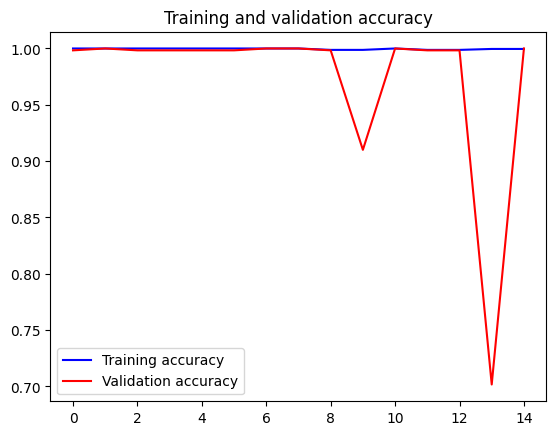

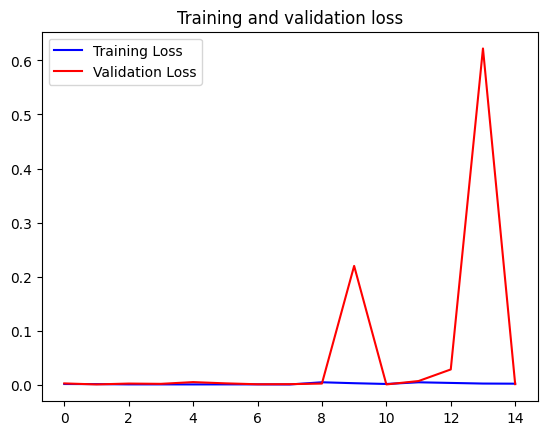

In [29]:
import matplotlib.pyplot as plt

acc = history_v3.history['accuracy']
val_acc = history_v3.history['val_accuracy']
loss = history_v3.history['loss']
val_loss = history_v3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [30]:
# Get the train accuracy
train_loss, train_accuracy = EfficientNetV2_model.evaluate(train_data, train_labels)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

# Get the val accuracy
val_loss, val_accuracy = EfficientNetV2_model.evaluate(val_data, val_labels)
print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)

75/75 [==============================] - 61s 800ms/step - loss: 5.2816e-05 - accuracy: 1.0000
Train Loss: 5.281620906316675e-05
Train Accuracy: 1.0
19/19 [==============================] - 15s 785ms/step - loss: 8.2021e-04 - accuracy: 1.0000
Val Loss: 0.0008202098542824388
Val Accuracy: 1.0


In [31]:
EfficientNetV2_model.save('EfficientNetV2_model.h5')
EfficientNetV2_model.save('EfficientNetV2_model')
!zip -r 'EfficientNetV2_model.zip' 'EfficientNetV2_model'

updating: EfficientNetV2_model/ (stored 0%)
updating: EfficientNetV2_model/assets/ (stored 0%)
updating: EfficientNetV2_model/saved_model.pb (deflated 92%)
updating: EfficientNetV2_model/fingerprint.pb (stored 0%)
updating: EfficientNetV2_model/keras_metadata.pb (deflated 96%)
updating: EfficientNetV2_model/variables/ (stored 0%)
updating: EfficientNetV2_model/variables/variables.index (deflated 77%)
updating: EfficientNetV2_model/variables/variables.data-00000-of-00001 (deflated 8%)


In [32]:
import pathlib

converter = tf.lite.TFLiteConverter.from_saved_model('EfficientNetV2_model')

# Set the optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./EfficientNetV2_model.tflite')
tflite_model_file.write_bytes(tflite_model)

6597520

In [33]:
import os

# Set the path to the test dataset folder
test_dataset_path = "/content/drive/MyDrive/dataset/Test"

# Load the test dataset
test_data = []
test_labels = []

# Iterate through the test dataset path and load the images
for category in os.listdir(test_dataset_path):
    category_path = os.path.join(test_dataset_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (150, 150))
        test_data.append(image)
        test_labels.append(category)

# Convert test_data and test_labels to numpy arrays
test_data = np.array(test_data)
test_labels = np.array(test_labels)

# Perform label encoding for test_labels
test_labels = label_encoder.transform(test_labels)

# Apply data normalization to test_data
test_data = test_data.astype('float32') / 255.0

# Create a dictionary to store the accuracy for each folder
folder_accuracy = {}

# Iterate over the folders in the test dataset
for folder in os.listdir(test_dataset_path):
    folder_path = os.path.join(test_dataset_path, folder)

    # Filter the test data and labels for the current folder
    folder_test_data = test_data[test_labels == label_encoder.transform([folder])[0]]
    folder_test_labels = test_labels[test_labels == label_encoder.transform([folder])[0]]

    # Evaluate the model on the current folder's test data
    folder_loss, folder_accuracy[folder] = EfficientNetV2_model.evaluate(folder_test_data, folder_test_labels, verbose=0)

# Print the accuracy for each folder
for folder, accuracy in folder_accuracy.items():
    print(f"Accuracy for folder {folder}: {accuracy}")

Accuracy for folder Grade 3: 1.0
Accuracy for folder Grade 2: 0.9399999976158142
Accuracy for folder Grade 1: 1.0


In [34]:
# Get the test accuracy
test_loss, test_accuracy = EfficientNetV2_model.evaluate(test_data, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

10/10 [==============================] - 8s 855ms/step - loss: 0.0632 - accuracy: 0.9800
Test Loss: 0.06318308413028717
Test Accuracy: 0.9800000190734863


In [35]:
# Make predictions on the test data
test_predictions = EfficientNetV2_model.predict(test_data)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(test_predictions, axis=1)

# Decode the predicted labels using the label encoder
predicted_classes = label_encoder.inverse_transform(predicted_labels)

# Compare the predicted classes with the true classes
for i in range(len(test_labels)):
    print("True Label: ", label_encoder.inverse_transform([test_labels[i]]))
    print("Predicted Label: ", predicted_classes[i])
    print("------------------------------------")

10/10 [==============================] - 9s 896ms/step
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
--------------

10/10 [==============================] - 7s 647ms/step


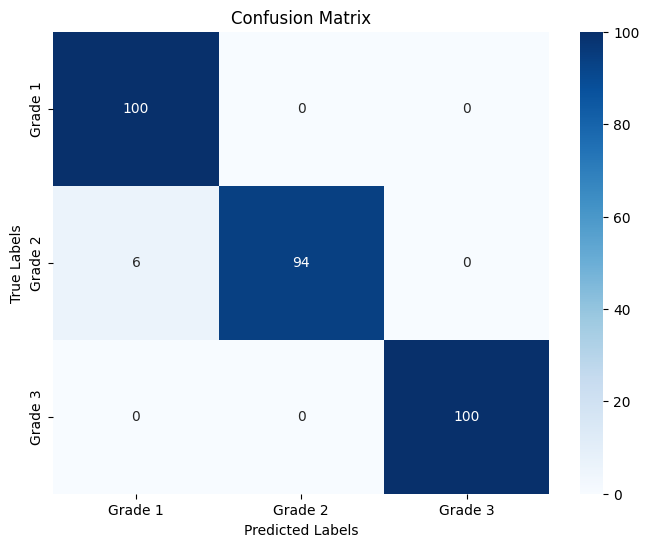

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Generate predictions on the test set
test_predictions = EfficientNetV2_model.predict(test_data)

# Convert the predicted probabilities to class labels
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Create a confusion matrix
cm = confusion_matrix(test_labels, test_predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

10/10 [==============================] - 7s 644ms/step


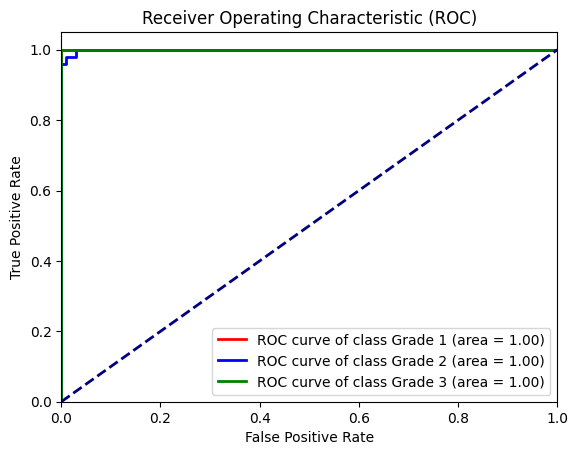

Macro-average ROC AUC: 0.9997333333333334


In [37]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Convert labels to binary format
binary_labels = label_binarize(test_labels, classes=np.arange(len(class_names)))

# Compute the predicted probabilities for each class
class_probabilities = EfficientNetV2_model.predict(test_data)

# Compute the macro-average ROC AUC score
roc_auc = roc_auc_score(binary_labels, class_probabilities, average='macro')

# Plot the ROC curve for each class
plt.figure()
lw = 2
colors = ['red', 'blue', 'green']  # Add more colors if there are more classes
for i, color in zip(range(len(class_names)), colors):
    fpr, tpr, _ = roc_curve(binary_labels[:, i], class_probabilities[:, i])
    roc_auc_class = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc_class))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print the macro-average ROC AUC score
print("Macro-average ROC AUC:", roc_auc)

In [38]:
from sklearn.metrics import classification_report

# Make predictions on the test data
test_predictions = EfficientNetV2_model.predict(test_data)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(test_predictions, axis=1)

# Decode the predicted labels using the label encoder
predicted_classes = label_encoder.inverse_transform(predicted_labels)

# Generate the classification report
report = classification_report(test_labels, predicted_labels, target_names=class_names)

# Print the classification report
print("Classification Report:")
print(report)

10/10 [==============================] - 8s 862ms/step
Classification Report:
              precision    recall  f1-score   support

     Grade 1       0.94      1.00      0.97       100
     Grade 2       1.00      0.94      0.97       100
     Grade 3       1.00      1.00      1.00       100

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300

